In [1]:
import gym
import gym_snake
from matplotlib import pyplot as plt
from array2gif import write_gif
import numpy as np
import cv2 as cv
import torch
import random
from more_itertools import sort_together
from copy import deepcopy



# Construct Environment
env = gym.make('snake-v0')
env.grid_size = 15, 15
observation = env.reset()  # Constructs an instance of the game

# Controller
game_controller = env.controller

# Grid
grid_object = game_controller.grid
grid_pixels = grid_object.grid

# Snake(s)
snakes_array = game_controller.snakes
snake_object1 = snakes_array[0]

observation = env.reset()
to_pixels = lambda x: cv.resize(x, env.grid_size)

def find_apple_coordinates_pixel_array(pixel_arr, food_color):
    indices = np.where(np.all(pixel_arr == food_color, axis=-1))
    indexes = list(zip(indices[1], indices[0]))
    return np.array(indexes[0])

def distances_to_walls(snake_obj, grid_size):
    up = snake_obj.head[1] - 1
    left = snake_obj.head[0] -1
    down = grid_size[1] - up
    right = grid_size[0] - left
    return np.array([up, right, down, left])
    

In [2]:
print(torch.cuda.is_available())
cuda = torch.device('cuda:0')

True


In [9]:
!sudo pip3 freeze > requirements.txt

[sudo] password for arattel: 


In [3]:
def feature_vector(snake_object, pixelarr, grid_size, food_color):
    direction_vector = np.zeros(4)
    direction_vector[snake_object.direction] = 1
    pixel_grid = to_pixels(pixelarr)
    apple_coord = find_apple_coordinates_pixel_array(pixel_grid, food_color)
    distances = distances_to_walls(snake_object, grid_size)
    return np.concatenate((direction_vector, apple_coord, distances))

print(feature_vector(snake_object1, grid_object.grid, env.grid_size, grid_object.FOOD_COLOR))

[ 0.  0.  1.  0.  1.  2.  3.  9. 12.  6.]


In [4]:
class GameNet(torch.nn.Module):
    def __init__(self):
        super(GameNet, self).__init__()
        self.fc1 = torch.nn.Linear(10, 14)
        self.fc2 = torch.nn.Linear(14, 4)
        self.act = torch.nn.Sigmoid()        
    
    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        return x.detach()
    
    def mutate(self, p=.15):
        state_dict = self.state_dict()
        keys = list(state_dict.keys())
        for key in keys:
            for index, weight  in enumerate(state_dict[key]):
                if random.uniform(0, 1) <= p:
                    delta = random.uniform(-.5, .5)
                    state_dict[key][index] += delta
        return self.load_state_dict(state_dict)
    
    def crossover(self, other, p=.3):
        state_dict0 = deepcopy(self.state_dict())
        state_dict1 = deepcopy(other.state_dict())
        keys = list(state_dict1.keys())
        for key in keys:
            if random.uniform(0, 1) <= p:
                x = np.random.randint(1, len(state_dict0[key]))
                state_dict0[key][:x], state_dict1[key][:x] = state_dict1[key][:x].clone(), state_dict0[key][:x].clone()
        
        child_net0 = GameNet()
        child_net1 = GameNet()
        child_net0.load_state_dict(state_dict0)
        child_net1.load_state_dict(state_dict1)
        return child_net0.to(cuda), child_net1.to(cuda)

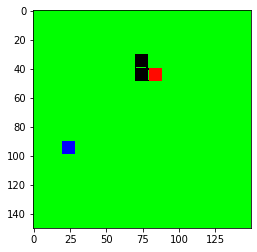

In [5]:
plt.imshow(env.step(snake_object1.RIGHT)[0])

In [6]:
def create_population(individuals=1000):
    generation = []
    for i in range(individuals):
        generation.append(GameNet().to(cuda))
    return generation



In [7]:
def calculate_fitness(individual):
    
    global env
    observation = env.reset()  # Constructs an instance of the game
    # Controller
    game_controller = env.controller
    # Grid
    grid_object = game_controller.grid
    grid_pixels = grid_object.grid
    # Snake(s)
    snakes_array = game_controller.snakes
    snake_object1 = snakes_array[0]
    to_pixels = lambda x: cv.resize(x, env.grid_size)
    
    env.render()
    fitness = 0
    features = feature_vector(snake_object1, grid_object.grid, env.grid_size, grid_object.FOOD_COLOR)
    features = torch.cuda.FloatTensor(features)
    action = np.argmax(individual.forward(features).cpu()).item()
     
    observation, reward, done, info = env.step(action)
    fitness += reward
    while not done:
        env.render()
        features = torch.cuda.FloatTensor(feature_vector(snake_object1, observation, env.grid_size, grid_object.FOOD_COLOR))
        action = np.argmax(individual.forward(features).cpu()).item()
        observation, reward, done, info = env.step(action)
        fitness += reward
    return fitness + 1

In [8]:
def create_mating_pool(fitness, population, to_choose):
    cumulative_fitness = sum(fitness)
    fitness = list(map(lambda x: x / cumulative_fitness, fitness))
    fitness, population = sort_together([fitness, population], reverse=True)
    mating_pool = []
    indexes = []
    for i in range(to_choose):
        p = np.random.uniform(0, 1)
        for j in range(len(fitness)):
            if fitness[j] >= p and fitness[j] < p:
                if j not in indexes:
                    mating_pool.append(population[j])
                    indexes.append(j)
                
        while len(mating_pool) <= i:
            index_to_append = random.randint(0, len(fitness) - 1)
            if index_to_append not in indexes:
                indexes.append(index_to_append)
                mating_pool.append(population[index_to_append])
                
    return mating_pool

In [18]:
#Initial population + configurations
n_individuals = 120
n_generations = 20
population = create_population(n_individuals)
percentage_to_save = .3


for i in range(n_generations):
    new_generation = []
    fitness = []
    for i in range(len(population)):
        fit_score = calculate_fitness(population[i])
        fitness.append(fit_score)
    print("Best result:", max(fitness))
    mating_pool = create_mating_pool(fitness, population, int(percentage_to_save * n_individuals))
    new_generation = []
    while len(new_generation) < n_individuals:
        sample = random.sample(mating_pool, 2)
        parent1, parent2 = sample[0], sample[1]
        child1, child2 = parent1.crossover(parent2)
        child1.mutate()
        child2.mutate()
        new_generation += [child1, child2]
    population = new_generation


Best result: 1
Best result: 1
Best result: 1
Best result: 1
Best result: 1
Best result: 1
Best result: 1
Best result: 1
Best result: 1
Best result: 1
Best result: 1
Best result: 1
Best result: 1
Best result: 1
Best result: 1
Best result: 1
Best result: 1
Best result: 1
Best result: 1
Best result: 1
